# Dairy Goods Sales Forecasting using PySpark and Tableau

# importing required libraries 

Installing PySpark

In [1]:
pip install pyspark

Note: you may need to restart the kernel to use updated packages.


importing required modules

In [2]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression, RandomForestRegressor,GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, sum, to_date
from pyspark.sql.types import DateType
from pyspark.sql import functions as F
from pyspark.sql.functions import dayofweek
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.sql.functions import year, month, dayofmonth, lit, when
from pyspark.sql.functions import col, concat, lit, concat_ws
from pyspark.sql.functions import sum
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate
from pyspark.ml import Pipeline
import calendar
import pyarrow as pa

Initializing a Spark session

In [3]:
spark = SparkSession.builder.appName("DairyGoodsSales").getOrCreate()

Loading the Dairy Good Sales dataset

In [4]:
data_path = "C:/Users/acer/Downloads/dairy_dataset.csv"

Storing the loaded data in the DataFrame

In [5]:
data_df=spark.read.csv(data_path, header=True, inferSchema=True)

# Data Preprocessing

 Identifying the number of rows and Columns in the data

In [6]:
num_rows = data_df.count()
num_cols = len(data_df.columns)

print("Number of rows:", num_rows)
print("Number of columns:", num_cols)

Number of rows: 4325
Number of columns: 23


Displaying the features and their data types

In [7]:
data_df.printSchema()

root
 |-- Location: string (nullable = true)
 |-- Total Land Area (acres): double (nullable = true)
 |-- Number of Cows: integer (nullable = true)
 |-- Farm Size: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Product ID: integer (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Brand: string (nullable = true)
 |-- Quantity (liters/kg): double (nullable = true)
 |-- Price per Unit: double (nullable = true)
 |-- Total Value: double (nullable = true)
 |-- Shelf Life (days): integer (nullable = true)
 |-- Storage Condition: string (nullable = true)
 |-- Production Date: date (nullable = true)
 |-- Expiration Date: date (nullable = true)
 |-- Quantity Sold (liters/kg): integer (nullable = true)
 |-- Price per Unit (sold): double (nullable = true)
 |-- Approx. Total Revenue(INR): double (nullable = true)
 |-- Customer Location: string (nullable = true)
 |-- Sales Channel: string (nullable = true)
 |-- Quantity in Stock (liters/kg): integer (nullable = true)

In [8]:
column_data = [(col_name, col_type) for col_name, col_type in data_df.dtypes]

print(tabulate(column_data, headers=["Column Name", "Data Type"], tablefmt="grid"))

+-------------------------------------+-------------+
| Column Name                         | Data Type   |
+=====================================+=============+
| Location                            | string      |
+-------------------------------------+-------------+
| Total Land Area (acres)             | double      |
+-------------------------------------+-------------+
| Number of Cows                      | int         |
+-------------------------------------+-------------+
| Farm Size                           | string      |
+-------------------------------------+-------------+
| Date                                | date        |
+-------------------------------------+-------------+
| Product ID                          | int         |
+-------------------------------------+-------------+
| Product Name                        | string      |
+-------------------------------------+-------------+
| Brand                               | string      |
+---------------------------

Displaying records in the DataFrame 

In [9]:
data_df.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


# Data Cleaning


Renaming Column Names

In [10]:
data_df = data_df.withColumnRenamed('Approx. Total Revenue(INR)','Approx_Total_Revenue_INR')

Checking for missing values

In [11]:
missing_columns = [col_name for col_name in data_df.columns if data_df.filter(data_df[col_name].isNull()).count() > 0]

Handling missing values if necessary Fill missing values with "N/A" or  Droping rows with missing values

In [12]:
if missing_columns:
    fill_value = "N/A"
    for col_name in missing_columns:
        data_df = data_df.withColumn(col_name, when(data_df[col_name].isNull(), fill_value).otherwise(data_df[col_name]))
    data_df = data_df.dropna(subset=missing_columns)

if len(missing_columns) == 0:
    print("No missing values found.")
else:
    print("There are missing values.")


No missing values found.


Evaluating missing data count

In [13]:
missing_data_counts = data_df.agg(*[sum(data_df[c].isNull().cast("int")).alias(c) for c in data_df.columns])
missing_data_counts.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Missing Value Heatmap

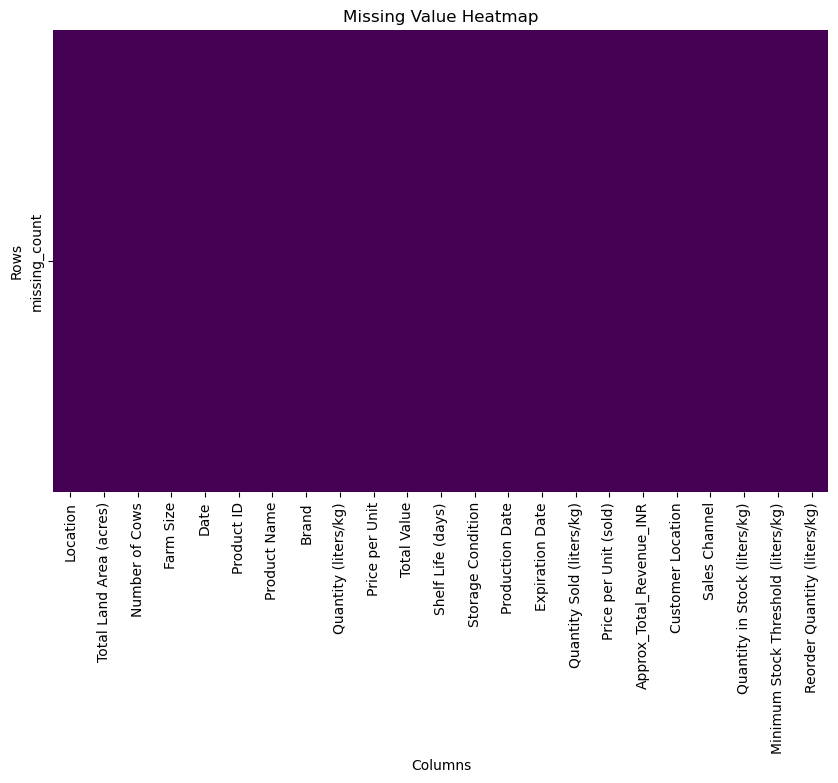

In [14]:
missing_data_counts = data_df.agg(*[F.sum(F.col(c).isNull().cast("int")).alias(c) for c in data_df.columns])

missing_data_pd = missing_data_counts.toPandas().transpose()
missing_data_pd.columns = ['missing_count']

# Creating a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(missing_data_pd.transpose().isna(), cbar=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.show()

Checking Duplicate values

In [15]:
def check_duplicate(df):
    if df.dropDuplicates().count() == df.count():
        return 'Data Is clean, No Duplicate Data Found.'
    else:
        return 'There are duplicate Data in DataFrame, Needed To Be Removed.'

result = check_duplicate(data_df)

print(result)

Data Is clean, No Duplicate Data Found.


Coverting date Columns to proper date format

In [16]:
date_columns = ['Date', 'Production Date', 'Expiration Date']

for col in date_columns:
    data_df = data_df.withColumn(col, to_date(col, 'yyyy-MM-dd').cast(DateType()))

In [17]:
data_df.toPandas()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


Saving the cleaned dataset in a  new csv file

In [18]:
data_df.toPandas().to_csv("dairy_dataset.csv", index=False)

# SPARK SQL

In [19]:
data_df.createOrReplaceTempView("sales_data_view")

In [20]:
result = spark.sql("SELECT * FROM sales_data_view")

result.toPandas()


,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,2022-02-16,2022-02-21,352,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,2022-03-22,2022-04-14,68,58.39,3970.52,Kerala,Retail,750,87.41,114.37
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,2020-01-04,2020-01-11,141,89.46,12613.86,Haryana,Retail,442,33.47,153.66
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,2022-10-02,2022-10-09,2,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84


# Feature Selection  

Feature Columns for analysis

In [21]:
feature_columns = ['Customer Location', 'Sales Channel', 'Product ID', 'Quantity (liters/kg)', 'Price per Unit (sold)',  'Approx_Total_Revenue_INR','Date', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)']
target_column = 'Quantity Sold (liters/kg)'

# Feature Engineerig

Extracting Year,Month,Day from Date column

In [22]:
data_df = data_df.withColumn("Year", F.year("date")) \
                 .withColumn("Month", F.month("date")) \
                 .withColumn("Day", F.dayofmonth("date"))

data_df.toPandas()


,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Price per Unit (sold),Approx_Total_Revenue_INR,Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Year,Month,Day
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03,2022,2,17
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10,2021,12,1
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83,2022,2,28
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,28.92,17380.92,Rajasthan,Online,222,74.50,57.68,2019,6,9
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40,2020,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4320,Delhi,748.71,89,Medium,2022-02-24,6,Curd,Mother Dairy,554.90,88.45,...,87.20,30694.40,Uttar Pradesh,Online,202,98.07,33.53,2022,2,24
4321,Jharkhand,385.91,29,Large,2022-05-14,4,Yogurt,Palle2patnam,818.33,55.35,...,58.39,3970.52,Kerala,Retail,750,87.41,114.37,2022,5,14
4322,Chandigarh,311.54,65,Small,2020-01-05,6,Curd,Mother Dairy,583.56,92.61,...,89.46,12613.86,Haryana,Retail,442,33.47,153.66,2020,1,5
4323,Maharashtra,890.55,90,Small,2022-10-25,6,Curd,Raj,3.10,15.30,...,10.56,21.12,Jharkhand,Wholesale,1,58.25,160.84,2022,10,25


In [23]:
data_df.select("Month").distinct().show()

+-----+
|Month|
+-----+
|   12|
|    1|
|    6|
|    3|
|    5|
|    9|
|    4|
|    8|
|    7|
|   10|
|   11|
|    2|
+-----+



In [24]:
data_df.select('Year').distinct().show()

+----+
|Year|
+----+
|2022|
|2019|
|2020|
|2021|
+----+



# Categorical Variable Encoding

Creating a StringIndexer for each categorical column

In [25]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index") for col in ['Customer Location', 'Sales Channel']]

Creating a OneHotEncoder for the indexed columns

In [26]:
encoder = [OneHotEncoder(inputCol=col+"_index", outputCol=col+"_encoded") for col in ['Customer Location', 'Sales Channel']]

Combining indexers and encoder into a single pipeline

In [27]:
pipeline = Pipeline(stages=indexers + encoder)

Fitting and transforming the data

In [28]:
data_with_encoded = pipeline.fit(data_df).transform(data_df)

 Feature columns after feature engineering and Categorical Variable Encoding

In [29]:
feature_columns = ['Customer Location_encoded', 'Sales Channel_encoded', 'Product ID', 'Quantity (liters/kg)', 'Price per Unit (sold)',  'Approx_Total_Revenue_INR', 'Year', 'Day', 'Month', 'Quantity in Stock (liters/kg)', 'Minimum Stock Threshold (liters/kg)']
target_column = 'Quantity Sold (liters/kg)'

Assembling features using VectorAssembler

In [30]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_with_features = assembler.transform(data_with_encoded)

# Model Selection

Spliting data into training and testing sets

In [31]:
train_data, test_data = data_with_features.randomSplit([0.8, 0.2], seed=42)

Initializing models

In [32]:
linear_reg = LinearRegression(labelCol=target_column, featuresCol="features")
rf_reg = RandomForestRegressor(labelCol=target_column, featuresCol="features")
gbt_reg = GBTRegressor(labelCol=target_column, featuresCol="features")

Training models

In [33]:
linear_reg_model = linear_reg.fit(train_data)
rf_reg_model = rf_reg.fit(train_data)
gbt_reg_model = gbt_reg.fit(train_data)

Making predictions

In [34]:
linear_reg_predictions = linear_reg_model.transform(test_data)
rf_reg_predictions = rf_reg_model.transform(test_data)
gbt_reg_predictions = gbt_reg_model.transform(test_data)

Evaluating Models using RMSE,MAE,R2,RMSE metrics

In [35]:
evaluator = RegressionEvaluator(labelCol=target_column, metricName="rmse")
mae_evaluator = RegressionEvaluator(labelCol=target_column, metricName="mae")
r2_evaluator = RegressionEvaluator(labelCol=target_column, metricName="r2")
mse_evaluator = RegressionEvaluator(labelCol=target_column, metricName="mse")

Linear Regression Evaluation

In [36]:
linear_reg_rmse = evaluator.evaluate(linear_reg_predictions)
linear_reg_mse = mse_evaluator.evaluate(linear_reg_predictions)
linear_reg_mae = mae_evaluator.evaluate(linear_reg_predictions)
linear_reg_r2 = r2_evaluator.evaluate(linear_reg_predictions)

print("Linear Regression RMSE:", linear_reg_rmse)
print("Linear Regression (MSE):", linear_reg_mse)
print("Linear Regression MAE:", linear_reg_mae)
print("Linear Regression R2:", linear_reg_r2)


Linear Regression RMSE: 0.29927950772269873
Linear Regression (MSE): 0.08956822374274089
Linear Regression MAE: 0.25994561175511915
Linear Regression R2: 0.9999981314291454


Random Forest Evaluation

In [37]:
rf_reg_rmse = evaluator.evaluate(rf_reg_predictions)
rf_reg_mse = mse_evaluator.evaluate(rf_reg_predictions)
rf_reg_mae = mae_evaluator.evaluate(rf_reg_predictions)
rf_reg_r2 = r2_evaluator.evaluate(rf_reg_predictions)

print("Random Forest Regression RMSE:", rf_reg_rmse)
print("Random Forest Regression  (MSE):", rf_reg_mse)
print("Random Forest Regression MAE:", rf_reg_mae)
print("Random Forest Regression R2:", rf_reg_r2)


Random Forest Regression RMSE: 63.6569584180055
Random Forest Regression  (MSE): 4052.2083550316815
Random Forest Regression MAE: 48.79430608348238
Random Forest Regression R2: 0.9154628939515653


Gradient Boosted Tree Regression Evaluation

In [38]:
gbt_reg_rmse = evaluator.evaluate(gbt_reg_predictions)
gbt_reg_mse = mse_evaluator.evaluate(gbt_reg_predictions)
gbt_reg_mae = mae_evaluator.evaluate(gbt_reg_predictions)
gbt_reg_r2 = r2_evaluator.evaluate(gbt_reg_predictions)

print("Gradient Boosted Tree Regression RMSE:", gbt_reg_rmse)
print("Gradient Boosted Tree Regression (MSE):", gbt_reg_mse)
print("Gradient Boosted Tree Regression MAE:", gbt_reg_mae)
print("Gradient Boosted Tree Regression R2:", gbt_reg_r2)

Gradient Boosted Tree Regression RMSE: 33.39012020751064
Gradient Boosted Tree Regression (MSE): 1114.9001274720104
Gradient Boosted Tree Regression MAE: 22.18319718442832
Gradient Boosted Tree Regression R2: 0.9767409713292549


Displaying metrics results of each models in a table

In [39]:
metrics = ['RMSE', 'MSE', 'MAE', 'R2']
linear_reg_metrics = [linear_reg_rmse, linear_reg_mse, linear_reg_mae, linear_reg_r2]
rf_reg_metrics = [rf_reg_rmse, rf_reg_mse, rf_reg_mae, rf_reg_r2]
gbt_reg_metrics = [gbt_reg_rmse, gbt_reg_mse, gbt_reg_mae, gbt_reg_r2]

In [40]:
model_names = ['Linear Regression', 'Random Forest Regression', 'Gradient Boosted Tree Regression']

In [41]:
table_data = []
for model, model_metrics in zip(model_names, [linear_reg_metrics, rf_reg_metrics, gbt_reg_metrics]):
    table_data.append([model] + model_metrics)

In [42]:
table = tabulate(table_data, headers=['Model'] + metrics, tablefmt='grid')

In [43]:
df = spark.createDataFrame(table_data, ['Model', *metrics]).toPandas()
print(df)

Py4JJavaError: An error occurred while calling o1208.collectToPython.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 338.0 failed 1 times, most recent failure: Lost task 4.0 in stage 338.0 (TID 308) (192.168.1.76 executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2844)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2780)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2779)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2779)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1242)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1242)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3048)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2982)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2971)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:984)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2398)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2419)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2438)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2463)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1046)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1045)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4160)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4334)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4332)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:900)
	at org.apache.spark.sql.execution.SQLExecution$.withNewExecutionId(SQLExecution.scala:66)
	at org.apache.spark.sql.Dataset.withAction(Dataset.scala:4332)
	at org.apache.spark.sql.Dataset.collectToPython(Dataset.scala:4157)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.rdd.MapPartitionsRDD.compute(MapPartitionsRDD.scala:52)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:364)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:328)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:161)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.waitForNewConnection(Native Method)
	at java.base/java.net.PlainSocketImpl.socketAccept(PlainSocketImpl.java:163)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:458)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 32 more


Scatter plots for each model's predicted versus actual values

Plotting Predicted vs. Actual for each model

In [44]:
linear_reg_pd = linear_reg_predictions.select(target_column, "prediction").toPandas()
rf_reg_pd = rf_reg_predictions.select(target_column, "prediction").toPandas()
gbt_reg_pd = gbt_reg_predictions.select(target_column, "prediction").toPandas()

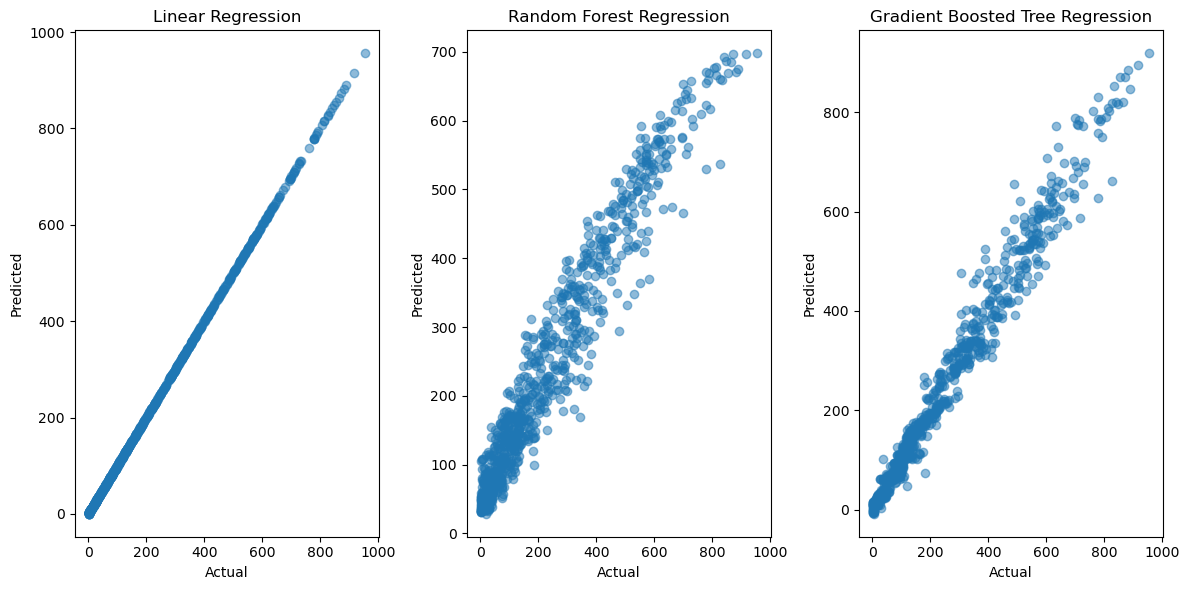

In [45]:
plt.figure(figsize=(12, 6))

plt.subplot(131)
plt.scatter(linear_reg_pd[target_column], linear_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Linear Regression")

plt.subplot(132)
plt.scatter(rf_reg_pd[target_column], rf_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Random Forest Regression")

plt.subplot(133)
plt.scatter(gbt_reg_pd[target_column], gbt_reg_pd["prediction"], alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosted Tree Regression")

plt.tight_layout()
plt.show()

Actual vs Predicted Quantity sold on a Monthly Basis

Group by year and month and sum the actual and predicted quantities

In [46]:
monthly_actual = test_data.groupBy("Month").sum("Quantity Sold (liters/kg)").withColumnRenamed("sum(Quantity Sold (liters/kg))", "Actual Quantity")
linear_reg_monthly_predictions = linear_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")
rf_reg_monthly_predictions = rf_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")
gbt_reg_monthly_predictions = gbt_reg_predictions.groupBy("Month").sum("prediction").withColumnRenamed("sum(prediction)", "Predicted Quantity")

monthly_actual_pd = monthly_actual.orderBy("Month").toPandas()
linear_reg_monthly_pd = linear_reg_monthly_predictions.orderBy("Month").toPandas()
rf_reg_monthly_pd = rf_reg_monthly_predictions.orderBy("Month").toPandas()
gbt_reg_monthly_pd = gbt_reg_monthly_predictions.orderBy("Month").toPandas()

In [47]:
monthly_actual_pd["Month"] = monthly_actual_pd["Month"].apply(lambda x: calendar.month_name[x])
linear_reg_monthly_pd["Month"] = linear_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])
rf_reg_monthly_pd["Month"] = rf_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])
gbt_reg_monthly_pd["Month"] = gbt_reg_monthly_pd["Month"].apply(lambda x: calendar.month_name[x])

Actual vs. Predicted Quantity Sold on a Monthly Basis (Linear Regression)

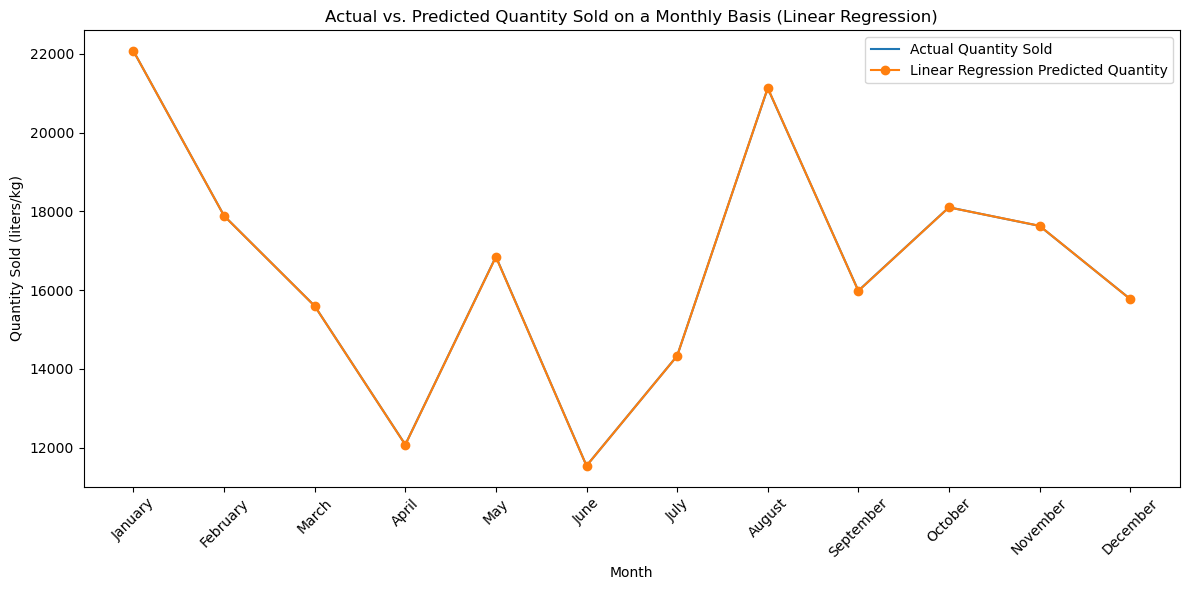

In [48]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(linear_reg_monthly_pd["Month"], linear_reg_monthly_pd["Predicted Quantity"], marker='o', label='Linear Regression Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Linear Regression)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Actual vs. Predicted Quantity Sold on a Monthly Basis (Random Forest)

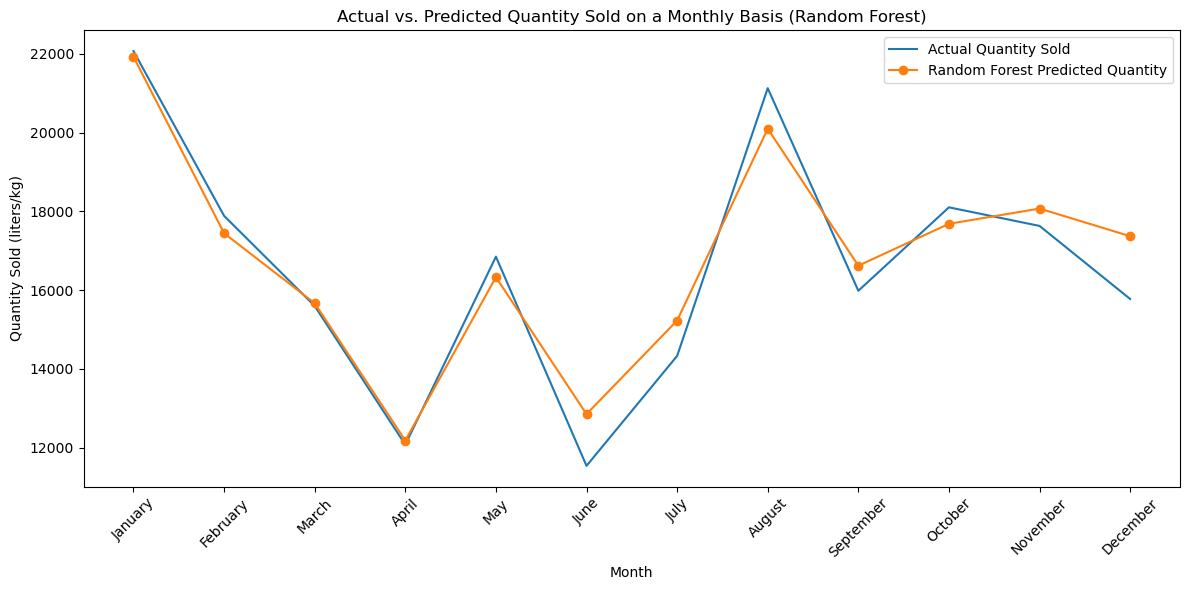

In [49]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(rf_reg_monthly_pd["Month"], rf_reg_monthly_pd["Predicted Quantity"], marker='o', label='Random Forest Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Random Forest)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Actual vs. Predicted Quantity Sold on a Monthly Basis (Gradient Boosted Tree)

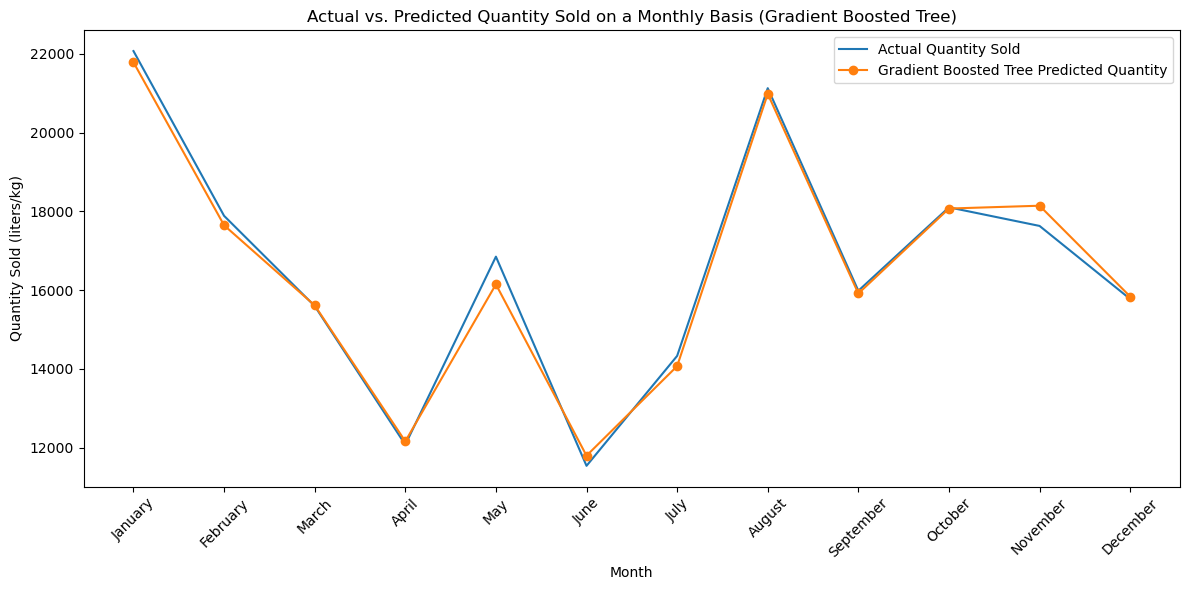

In [50]:
plt.figure(figsize=(12, 6))

plt.plot(monthly_actual_pd["Month"], monthly_actual_pd["Actual Quantity"], label='Actual Quantity Sold')
plt.plot(gbt_reg_monthly_pd["Month"], gbt_reg_monthly_pd["Predicted Quantity"], marker='o', label='Gradient Boosted Tree Predicted Quantity')

plt.xlabel('Month')
plt.ylabel('Quantity Sold (liters/kg)')
plt.title('Actual vs. Predicted Quantity Sold on a Monthly Basis (Gradient Boosted Tree)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()